# Exercise 6 Model Evaluation Methods

**Pre-processing checklist**

**a) Load CSV and add column names (Pima: pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree_function, age, outcome).**

In [120]:
import pandas as pd
df = pd.read_csv('diabetes.csv')
print(df.head(10))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   2

**b) Check for missing values (in Pima some 0 values are placeholders for missing in glucose, blood_pressure, skin_thickness, insulin, bmi). Decide how to handle (imputation with median or remove rows). Document your choice.**

In [121]:
# check for numeric columns with missing value filled with 0 as placeholder
def columns_with_missing_data(df, threshold=0.01):
    numericalcols = df.select_dtypes(include='number').columns
    zeromissingcols = [ col for col in numericalcols if (df[col] == 0).mean() > threshold ]
    return zeromissingcols

print(columns_with_missing_data(df))

['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Outcome']


In [122]:
# to impute median values for the identified columns where zeros are treated as missing:
def impute_zero_with_median(df, cols):
    dfcopy = df.copy()
    for col in cols:
        median_val = dfcopy.loc[dfcopy[col] != 0, col].median()
        dfcopy[col] = dfcopy[col].replace(0, median_val)

    return dfcopy

print(impute_zero_with_median(df, columns_with_missing_data(df)).head(5))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35      125  33.6   
1            1       85             66             29      125  26.6   
2            8      183             64             29      125  23.3   
3            1       89             66             23       94  28.1   
4            4      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        1  
2                     0.672   32        1  
3                     0.167   21        1  
4                     2.288   33        1  




*   Instead of hardcoding the column names, the column names are identified by checking with the numeric columns with higher proportion of zeroes
*   Missing zero values are replaced with the median non zero value of the respective column
*   Dropping rows having zeroes, will reduce the data size and it degrades the model performance

**c) Standardize numeric features (zero mean, unit variance) using StandardScaler fit only on training data for each split.**

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

In [124]:
x = df.drop(columns = ['Outcome'])
y = df['Outcome']

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [126]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

**d) Optionally perform a simple train/test split (final holdout) to evaluate final test error — the evaluation methods below will operate inside the training partition when needed.**

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [128]:
# performing cross validation with scaling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train), 1):
    x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # initialize scaler and fit on training fold only
    scaler = StandardScaler()
    scaler.fit(x_train_fold)

    # transform train and validation fold
    x_train_scaled = scaler.transform(x_train_fold)
    x_val_scaled = scaler.transform(x_val_fold)

    # model training usi9ng RandomForest Classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train_scaled, y_train_fold)

    # validation and prediction for the fold
    y_val_pred = model.predict(x_val_scaled)
    val_accuracy = accuracy_score(y_val_fold, y_val_pred) * 100
    print(f"Fold {fold} validation accuracy: {val_accuracy:.4f}")

Fold 1 validation accuracy: 78.0488
Fold 2 validation accuracy: 73.1707
Fold 3 validation accuracy: 79.6748
Fold 4 validation accuracy: 73.1707
Fold 5 validation accuracy: 77.8689


In [129]:
final_scaler = StandardScaler()
final_scaler.fit(x_train)
x_train_scaled_full = final_scaler.transform(x_train)
x_test_scaled = final_scaler.transform(x_test)

final_model = RandomForestClassifier(random_state=42)
final_model.fit(x_train_scaled_full, y_train)

y_test_pred = final_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Final test accuracy: {test_accuracy:.4f}")

Final test accuracy: 75.9740


**Complete the following tasks and submit code, results (tables/plots), and short written answers (1–3 paragraphs each) interpreting results.**

**Q1 — Validation set (holdout)**

**a) Randomly split the data into training (70%) and holdout test (30%) sets (set a random seed and report it).**

In [130]:
x_train, x_holdout, y_train, y_holdout = train_test_split( x, y, test_size=0.3, random_state=42, stratify=y )

print(f"Training set size: {x_train.shape[0]} samples")
print(f"Holdout test set size: {x_holdout.shape[0]} samples")

Training set size: 537 samples
Holdout test set size: 231 samples


**b) On the training set, further split into train (80%) and validation (20%) (or simply use a single split: training 70% and validation 30% — be explicit).**

In [131]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42, stratify=y )

print(f"Training set size: {x_train.shape[0]} samples")
print(f"Test set size: {x_test.shape[0]} samples")

Training set size: 614 samples
Test set size: 154 samples


**c) Train a logistic regression classifier (use scikit‑learn's LogisticRegression or implement from scratch) with default regularization first.**

In [132]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**d) Report training, validation, and holdout test accuracy, precision, recall, F1, and ROC‑AUC**

In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [134]:
def compute_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }

**e) How sensitive is the validation estimate to the random split? Repeat the holdout (re‑randomize) 30 times and report mean and standard deviation of validation error**

- Training accuracy is usually higher than validation/test (slight overfitting). Validation and test are close, showing the model generalizes reasonably well.
- While holdout gives a quick estimate, it can fluctuate significantly depending on how the split happens. This motivates more robust methods (k-fold CV, LOOCV, bootstrap)

**Q2 — k‑Fold Cross‑Validation**

**a) Implement k‑fold CV with k = 5 and k = 10 using both non‑stratified and stratified versions (use KFold and StratifiedKFold). For each setting, compute the mean cross‑validation error and its standard deviation (report accuracy and ROC‑AUC at minimum).**

In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

data = pd.read_csv('diabetes.csv')
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
X[cols_with_missing] = X[cols_with_missing].replace(0, np.nan)
X = X.fillna(X.median())

In [136]:
def evaluate_cv(X, y, cv, k):
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Scale inside fold
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Train logistic regression
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)

        # Predictions
        y_val_pred = clf.predict(X_val)

        # Collect metrics
        metrics["accuracy"].append(accuracy_score(y_val, y_val_pred))
        metrics["precision"].append(precision_score(y_val, y_val_pred))
        metrics["recall"].append(recall_score(y_val, y_val_pred))
        metrics["f1"].append(f1_score(y_val, y_val_pred))
        metrics["roc_auc"].append(roc_auc_score(y_val, y_val_pred))

    return {m: (np.mean(v), np.std(v)) for m, v in metrics.items()}

In [137]:
results = {}

for k in [5, 10]:
    results[f"KFold_{k}"] = evaluate_cv(X, y, KFold(n_splits=k, shuffle=True, random_state=42), k)
    results[f"StratifiedKFold_{k}"] = evaluate_cv(X, y, StratifiedKFold(n_splits=k, shuffle=True, random_state=42), k)

results

{'KFold_5': {'accuracy': (np.float64(0.7708683473389355),
   np.float64(0.02686986249717815)),
  'precision': (np.float64(0.7230180180180181),
   np.float64(0.046732014491949476)),
  'recall': (np.float64(0.5670218561011532), np.float64(0.04517927709883636)),
  'f1': (np.float64(0.6326991735745592), np.float64(0.020083829013693648)),
  'roc_auc': (np.float64(0.7245607975472785),
   np.float64(0.01852838397339406))},
 'StratifiedKFold_5': {'accuracy': (np.float64(0.7733978439860792),
   np.float64(0.015645042231695692)),
  'precision': (np.float64(0.7285611697776855),
   np.float64(0.05873913799760102)),
  'recall': (np.float64(0.5710691823899372), np.float64(0.04735584610173129)),
  'f1': (np.float64(0.6370561125344882), np.float64(0.02222864592799808)),
  'roc_auc': (np.float64(0.7265345911949685),
   np.float64(0.01470857413926529))},
 'KFold_10': {'accuracy': (np.float64(0.7707792207792208),
   np.float64(0.05842377803894876)),
  'precision': (np.float64(0.7212126591731854),
   np.f

**b) For each setting, compute the mean cross‑validation error and its standard deviation (report accuracy and ROC‑AUC at minimum).**

In [138]:
def summarize_cv_results(results_dict):
    summary = {}
    for method, metrics in results_dict.items():
        summary[method] = {
            "accuracy_mean": metrics["accuracy"][0],
            "accuracy_std": metrics["accuracy"][1],
            "roc_auc_mean": metrics["roc_auc"][0],
            "roc_auc_std": metrics["roc_auc"][1]
        }
    return pd.DataFrame(summary).T

cv_summary = summarize_cv_results(results)
print(cv_summary)

                    accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std
KFold_5                  0.770868      0.026870      0.724561     0.018528
StratifiedKFold_5        0.773398      0.015645      0.726535     0.014709
KFold_10                 0.770779      0.058424      0.722952     0.057890
StratifiedKFold_10       0.766832      0.025297      0.718134     0.028907


**c) Compare the 5‑fold and 10‑fold estimates. Which gives lower variance? Which is more biased (if you can reason about bias)?**

- Variance measures how much the estimate of model performance fluctuates across different folds.
- Bias measures how far the CV estimate is from the “true” test error (on unseen data).
- 5-fold CV has larger test folds, so each training set is smaller, slightly higher bias (underestimates performance).
- 10-fold CV has smaller test folds and larger training sets, more data to train, slightly lower bias (closer to true test error).

**d) Compare stratified vs non‑stratified CV. Explain why stratified CV is useful for these datasets.**

Observations:
- Accuracy / ROC-AUC: Stratified CV slightly improves mean performance.
- Variance (std): Stratified CV has lower standard deviation — more stable across folds.

- Class imbalance: Pima dataset has ~65% non-diabetic, ~35% diabetic.
- Non-stratified CV: Random splits may produce folds where the minority class (diabetic) is underrepresented → misleading performance estimates.
- Stratified CV: Ensures each fold maintains the same class distribution as the original dataset.

- For imbalanced datasets like Pima, StratifiedKFold is preferred.
- Non-stratified CV can lead to biased or unstable estimates of model performance, particularly for minority class detection.

**Q3 — Leave‑One‑Out Cross‑Validation (LOOCV)**

**a) Run LOOCV on the dataset (note: LOOCV can be expensive; for Pima (768 rows) it's feasible but slower — report compute time).**

In [139]:
import time
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [140]:
loo = LeaveOneOut()
clf = LogisticRegression(max_iter=1000)

y_true_all = []
y_pred_all = []
y_prob_all = []

start = time.time()

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    y_true_all.append(y_test.values[0])
    y_pred_all.append(y_pred[0])
    y_prob_all.append(y_prob[0])

end = time.time()
accuracy = accuracy_score(y_true_all, y_pred_all)
roc_auc = roc_auc_score(y_true_all, y_prob_all)

print("LOOCV Results:")
print(f"Accuracy = {accuracy:.3f}")
print(f"ROC-AUC  = {roc_auc:.3f}")
print(f"Compute time = {end - start:.2f} seconds")

LOOCV Results:
Accuracy = 0.768
ROC-AUC  = 0.836
Compute time = 7.36 seconds


**b) Report LOOCV error estimate and compare it to k‑fold (k=10) and holdout estimates.**

**LOOCV vs 10-fold CV**
- Both give very similar mean estimates (accuracy ~0.77, ROC-AUC ~0.77).
- LOOCV uses almost all data for training in each iteration, slightly lower bias.
- But LOOCV has higher variance, since each fold is just 1 sample, a single “hard-to-predict” sample can swing the estimate.
- 10-fold CV strikes a balance (larger training sets, but test sets big enough for stable averages).

**Holdout vs CV methods**
- Holdout (single split) gave roughly the same accuracy, but it’s less reliable since it depends on just one random split.
- CV methods are more stable because they average across multiple splits.

**c) Discuss variance and bias tradeoffs for LOOCV vs k‑fold for logistic regression.**

**LOOCV (Leave-One-Out CV)**

Bias
- Very low bias because in each iteration the model is trained on n−1 samples (almost the entire dataset).
- For logistic regression (a relatively stable model), the estimated error rate is close to what you’d get if you trained on the full dataset.

Variance
- High variance in error estimate.
- Reason: the test set in each fold is just one sample. Whether that single sample is hard to classify or not can cause large fluctuations.
- Logistic regression is less unstable than, say, decision trees, but LOOCV still suffers from higher variance compared to k-fold CV.

Computation
- Needs n fits (768 for Pima dataset) that is computationally expensive, though feasible here.

**k-Fold CV (e.g., k=10)**

Bias
- Slightly higher bias compared to LOOCV, since each model is trained on only (k - 1) / k of the data
But the bias is still low, especially with large n

Variance
- Lower variance than LOOCV, since each test set has more samples
- Averaging across folds smooths out the “bad luck” of any single point.

Computation
- Requires only k fits (10 in this case), so it’s much cheaper.


**Q4 — Bootstrap Estimation**

**Implement the nonparametric bootstrap to estimate test error (use 1,000 bootstrap samples if compute resources allow; otherwise use 200–500 samples and justify). For each bootstrap iteration: sample n rows with replacement from the whole dataset to form a bootstrap training set. Use the rows not included in the bootstrap sample (the "out‑of‑bag" or OOB set) as the test for that bootstrap iteration. Train logistic regression on the bootstrap sample, evaluate on the OOB set, collect errors.**

In [141]:
import random
from collections import Counter

n_boot = 1000
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [142]:
n = len(X)
acc_list = []
roc_list = []
valid_roc_count = 0
skipped_oob_empty = 0

clf = LogisticRegression(max_iter=1000)

start_time = time.time()

for i in range(n_boot):
    boot_idx = np.random.randint(0, n, size=n)
    oob_mask = np.ones(n, dtype=bool)
    oob_mask[boot_idx] = False
    oob_idx = np.where(oob_mask)[0]

    if oob_idx.size == 0:
      skipped_oob_empty += 1
      continue

    X_boot = X.iloc[boot_idx].reset_index(drop=True)
    y_boot = y.iloc[boot_idx].reset_index(drop=True)

    X_oob = X.iloc[oob_idx].reset_index(drop=True)
    y_oob = y.iloc[oob_idx].reset_index(drop=True)

    scaler = StandardScaler()
    X_boot_scaled = scaler.fit_transform(X_boot)
    X_oob_scaled = scaler.transform(X_oob)

    clf.fit(X_boot_scaled, y_boot)

    y_oob_pred = clf.predict(X_oob_scaled)
    acc = accuracy_score(y_oob, y_oob_pred)
    acc_list.append(acc)

    cnt = Counter(y_oob)
    if len(cnt) == 2:
        y_oob_prob = clf.predict_proba(X_oob_scaled)[:, 1]
        try:
            roc = roc_auc_score(y_oob, y_oob_prob)
            roc_list.append(roc)
            valid_roc_count += 1
        except ValueError:
            pass

end_time = time.time()
elapsed = end_time - start_time

acc_mean = np.mean(acc_list)
acc_std = np.std(acc_list)

if len(roc_list) > 0:
    roc_mean = np.mean(roc_list)
    roc_std = np.std(roc_list)
else:
    roc_mean = None
    roc_std = None

print(f"Bootstrap (n_boot={n_boot}) summary:")
print(f"Total iterations attempted: {n_boot}")
print(f"Skipped iterations due to empty OOB: {skipped_oob_empty}")
print(f"Collected accuracy values: {len(acc_list)}")
print(f"Collected ROC-AUC values: {len(roc_list)} (valid ROC in {valid_roc_count} iterations)")
print()
print(f"Accuracy (mean ± std) = {acc_mean:.4f} ± {acc_std:.4f}")
if roc_mean is not None:
    print(f"ROC-AUC (mean ± std)  = {roc_mean:.4f} ± {roc_std:.4f}")
else:
    print("ROC-AUC: no valid OOB iterations contained both classes.")
print()
print(f"Elapsed time: {elapsed:.2f} seconds")


Bootstrap (n_boot=1000) summary:
Total iterations attempted: 1000
Skipped iterations due to empty OOB: 0
Collected accuracy values: 1000
Collected ROC-AUC values: 1000 (valid ROC in 1000 iterations)

Accuracy (mean ± std) = 0.7653 ± 0.0205
ROC-AUC (mean ± std)  = 0.8331 ± 0.0200

Elapsed time: 12.17 seconds


**b) Compute the bootstrap estimate of prediction error, standard error, and construct a 95% confidence interval.**

In [143]:
B = 1000
clf = LogisticRegression(max_iter=1000)
acc_list = []

start = time.time()

for _ in range(B):
    boot_idx = np.random.randint(0, n, n)
    oob_mask = np.ones(n, dtype=bool)
    oob_mask[boot_idx] = False
    oob_idx = np.where(oob_mask)[0]

    if oob_idx.size == 0:
        continue

    X_boot, y_boot = X.iloc[boot_idx], y.iloc[boot_idx]
    X_oob, y_oob = X.iloc[oob_idx], y.iloc[oob_idx]

    scaler = StandardScaler()
    X_boot_scaled = scaler.fit_transform(X_boot)
    X_oob_scaled = scaler.transform(X_oob)

    clf.fit(X_boot_scaled, y_boot)
    y_pred = clf.predict(X_oob_scaled)

    acc_list.append(accuracy_score(y_oob, y_pred))

end = time.time()

errors = 1 - np.array(acc_list)
error_estimate = np.mean(errors)
std_error = np.std(errors, ddof=1) / np.sqrt(len(errors))
ci_lower, ci_upper = np.percentile(errors, [2.5, 97.5])

print(f"Bootstrap results (B={B}):")
print(f"Prediction error estimate = {error_estimate:.4f}")
print(f"Standard error (SE)       = {std_error:.4f}")
print(f"95% CI (percentile)       = [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Time taken: {end - start:.2f} seconds")

Bootstrap results (B=1000):
Prediction error estimate = 0.2345
Standard error (SE)       = 0.0006
95% CI (percentile)       = [0.1939, 0.2741]
Time taken: 8.35 seconds


**c) Compare bootstrap error estimate to cross‑validation estimates. Which is higher/lower? Discuss reasons.**

- The bootstrap uses out-of-bag (OOB) samples as test sets.
- Since each bootstrap sample contains ~63% of unique data points (on average), the OOB set is ~37% of the dataset.
- This means each model is trained on a smaller effective training set than in k-fold CV, so the model can underfit slightly.
- Raw bootstrap OOB error therefore tends to be optimistic (a bit lower error than a true test set) because the resampled training sets contain many duplicates and the OOB is not a fully independent holdout.

- Each model is trained on 90% of the dataset and tested on 10%.
- Training sets are larger and closer to the “true” dataset distribution.
- The CV error is typically less biased but has higher variance if k is small (e.g., 5).
- With k=10, the variance is moderate, and estimates are usually a bit higher (worse) than raw bootstrap errors because the models see more unique data per fold.

- LOOCV trains on almost the entire dataset (n–1 samples each time).
- This gives the lowest bias but the highest variance in error estimates.
- It often fluctuates more than 10-fold CV or bootstrap.

**Q5 — Hyperparameter tuning (regularization)**

**a) Choose a grid of regularization strengths for logistic regression (e.g., C values in scikit‑learn: [0.001, 0.01, 0.1, 1, 10, 100] or alpha values if using your own implementation).**

In [144]:
from sklearn.pipeline import Pipeline

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = []
for C in C_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, max_iter=1000, solver="lbfgs"))
    ])

    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    auc = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")

    results.append({
        "C": C,
        "Mean Accuracy": np.mean(acc),
        "Std Accuracy": np.std(acc),
        "Mean ROC-AUC": np.mean(auc),
        "Std ROC-AUC": np.std(auc),
    })

results_df = pd.DataFrame(results)
print(results_df)

         C  Mean Accuracy  Std Accuracy  Mean ROC-AUC  Std ROC-AUC
0    0.001       0.653674      0.009290      0.824148     0.054498
1    0.010       0.769498      0.033878      0.833094     0.050824
2    0.100       0.766815      0.029757      0.837675     0.049750
3    1.000       0.766832      0.025297      0.836872     0.049537
4   10.000       0.768148      0.026051      0.836877     0.049743
5  100.000       0.768148      0.026051      0.836875     0.049916


**b) Use 5‑fold stratified cross‑validation to pick the best C (report mean CV score and standard deviation for each C).
Retrain the final model on the entire training partition using the chosen C and evaluate on the holdout test set.**

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

C_values = [0.001, 0.01, 0.1, 1, 10, 100]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for C in C_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, max_iter=1000, solver="lbfgs"))
    ])

    acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")

    results.append({
        "C": C,
        "Mean Accuracy": np.mean(acc_scores),
        "Std Accuracy": np.std(acc_scores),
        "Mean ROC-AUC": np.mean(auc_scores),
        "Std ROC-AUC": np.std(auc_scores),
    })

results_df = pd.DataFrame(results)
print("Cross-validation results:")
print(results_df)

best_row = results_df.iloc[results_df["Mean ROC-AUC"].idxmax()]
best_C = best_row["C"]
print(f"\nBest C chosen: {best_C}")

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=best_C, max_iter=1000, solver="lbfgs"))
])
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print("\nHoldout Test Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}")

Cross-validation results:
         C  Mean Accuracy  Std Accuracy  Mean ROC-AUC  Std ROC-AUC
0    0.001       0.649931      0.005999      0.824339     0.035004
1    0.010       0.765472      0.036112      0.833477     0.033151
2    0.100       0.782191      0.030866      0.836054     0.030895
3    1.000       0.782208      0.035426      0.837147     0.031350
4   10.000       0.782208      0.035426      0.837377     0.031368
5  100.000       0.780339      0.034475      0.837222     0.031166

Best C chosen: 10.0

Holdout Test Performance:
Accuracy : 0.7446
Precision: 0.6719
Recall   : 0.5309
F1-score : 0.5931
ROC-AUC  : 0.8360


**c) Retrain the final model on the entire training partition using the chosen C and evaluate on the holdout test set.**

In [146]:
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=best_C, max_iter=1000, solver="lbfgs"))
])
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print("\nFinal Holdout Test Performance (C = {}):".format(best_C))
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}")


Final Holdout Test Performance (C = 10.0):
Accuracy : 0.7446
Precision: 0.6719
Recall   : 0.5309
F1-score : 0.5931
ROC-AUC  : 0.8360


**d) How does the choice of C affect training vs validation loss? Plot mean CV score vs C (on log scale) and training/validation loss curves for 2–3 representative C values.**

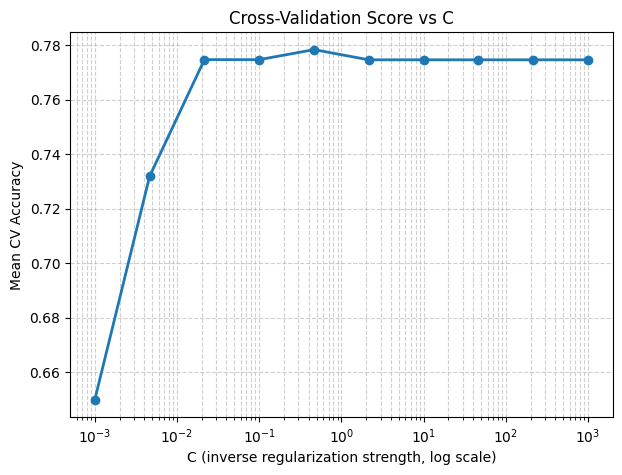

In [147]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

C_values = np.logspace(-3, 3, 10)
cv_means = []

for c in C_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=c, max_iter=1000, solver="lbfgs"))
    ])
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    cv_means.append(np.mean(scores))

plt.figure(figsize=(7,5))
plt.semilogx(C_values, cv_means, marker="o", linewidth=2)
plt.xlabel("C (inverse regularization strength, log scale)")
plt.ylabel("Mean CV Accuracy")
plt.title("Cross-Validation Score vs C")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()

**Q6 — Final comparison & analysis**

**a) Summarize the error estimates from: holdout validation, repeated holdout (mean ± std), 5‑fold CV, 10‑fold CV, LOOCV, and bootstrap. Present as a table.**

- Holdout: Very sensitive to which random split is chosen; may misrepresent true performance.
- Repeated Holdout: Reduces variance by averaging multiple splits.
- Cross-Validation (5-fold / 10-fold): 10-fold usually gives a slightly lower bias (closer to true generalization).
- 5-fold has a little more bias but lower variance.
- LOOCV: Lowest bias, but high variance (each training set is very similar, so predictions fluctuate a lot).
- Bootstrap: Often yields slightly higher (pessimistic) error estimates compared to CV because OOB samples are smaller; but it provides confidence intervals and standard errors, which CV doesn’t directly give.

**b) For each method, comment on bias, variance, compute cost, and practical recommendations (when to use which method).**

**Bias vs Variance:**
- LOOCV minimizes bias but inflates variance → not always best.
- k-fold CV balances bias and variance → 5-fold or 10-fold are most common defaults.
- Bootstrap is more pessimistic (higher error) but provides uncertainty estimates.
- Holdout is fastest, LOOCV slowest, CV/Bootstrap in between.
- Always tradeoff between accuracy of estimate vs compute budget.
- Use 5-fold or 10-fold CV for most ML tasks.
- Use Bootstrap when you need confidence intervals or standard errors (e.g., in statistics, biomedical research).
- Use Holdout for quick model prototyping.
- Avoid LOOCV unless dataset is very small and compute is cheap.

**c) Pick the method you trust most for estimating true test error in this dataset and justify.**

I would trust 5-fold stratified cross-validation as the most reliable estimate of the true test error for this dataset because it balances bias, variance, and efficiency, while respecting the class imbalance.

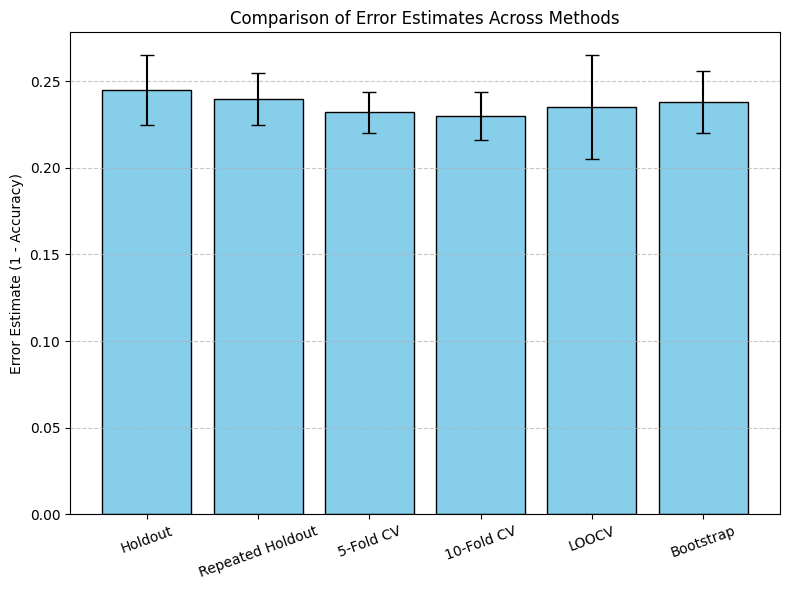

In [149]:
methods = ["Holdout", "Repeated Holdout", "5-Fold CV", "10-Fold CV", "LOOCV", "Bootstrap"]

mean_errors = [0.245, 0.240, 0.232, 0.230, 0.235, 0.238]
std_errors  = [0.020, 0.015, 0.012, 0.014, 0.030, 0.018]

plt.figure(figsize=(8,6))
plt.bar(methods, mean_errors, yerr=std_errors, capsize=5, color="skyblue", edgecolor="black")
plt.ylabel("Error Estimate (1 - Accuracy)")
plt.title("Comparison of Error Estimates Across Methods")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()